# Investigating Entity Extraction from User Feedback 

Hiya pure and client apps collect feedback from users. Can we extract entity names from this dataset and add them to our database?


Known Challenges:
- Feedback is often collected in unstructured format
- Users might report caller impersonating another person, or business
- Feedback is often short with one or two tokens
- Some apps only allow identity feedback on wrongly identified calls
- User feedback would assign names to spoofed numbers 

Findings:
- some users report an identity name when flagging the call as spam - this can be a fake identity! We would not want to add fake identities to our DB 

First, let's load some data. The initial data sample is obtained from sniffing the user-feedback kafka topic


In [8]:
import json
from itertools import islice
from pandas.io.json import json_normalize

# File contains json stream from user-feedback kafka topic
with open('uf_sample.json') as json_file:
    
    for line in islice(json_file, 2):
        dataline = json.loads(line)
        print(json.dumps(dataline, indent=4, sort_keys=True))
        print('***************')
        
        

{
    "context": {
        "currentCarrierId": {
            "mccMnc": "310/410",
            "type": "CurrentCarrierId"
        },
        "deviceInfo": "samsung/SM-G955U",
        "gatewayName": "hiya-edge/",
        "locationHint": {
            "countryCode": "US",
            "currentCarrierId": {
                "mccMnc": "310/410",
                "type": "CurrentCarrierId"
            },
            "ipAddress": "108.65.43.66",
            "locale": {
                "country": "US",
                "language": "en"
            },
            "ownerPhoneNumber": "+13104226918",
            "simCarrierId": {
                "mccMnc": "310/410",
                "type": "SimCarrierId"
            }
        },
        "osInfo": "Android28/G955USQU5DSC1",
        "productInfo": {
            "name": "HiyaAndroid",
            "version": "9.2.2-6280"
        },
        "userDetails": {
            "applicationUserId": "O2v9LZbouuX9fjjyzzPXahKNzvX2",
            "deviceId": "c97f4f603

Looking specifically at the user feedback:

In [9]:
with open('uf_sample.json') as json_file:    
    # Show samples of user feedback
    for line in islice(json_file, 10):
        dataline = json.loads(line)
        res = json_normalize(dataline)
        print(dataline['feedback'])
        print('***************')

{'comment': {'languageTag': 'en-US', 'str': 'Keep calling with a different number and claiming that you signed up for a career school with them At my age 85 no way  🙄👀🤔'}, 'reputation': {'feedbackType': 'abstain', 'category': 6}}
***************
{'comment': {'languageTag': 'en-US', 'str': 'Didnt even speak english.'}, 'reputation': {'feedbackType': 'abstain', 'category': 2}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 2}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'reputation': {'feedbackType': 'abstain', 'category': 8}, 'identity': {'feedbackType': 'abstain', 'name': ''}}
***************
{'comment': {'languageTag': 'en-US', 'str': 'employment specialist- hung up'}, 'reputation': {'feedbackType': 'abstain', 'category': 2}, 'identity'

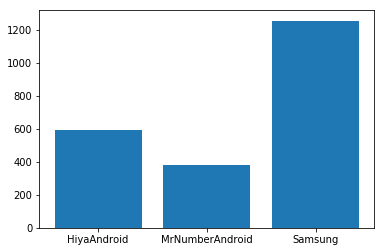

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import json

with open('uf_sample.json') as json_file:    
    product_names = []
    # Product Info
    for line in json_file:
        dataline = json.loads(line)
        product_names.append(dataline['context']['productInfo']['name'])
        
    keys, counts = np.unique(product_names, return_counts=True)
    plt.bar(keys, counts)
    plt.show()
    

In [12]:
import pandas as pd

with open('uf_sample.json') as json_file:    
    df = pd.DataFrame()
    # Product Info
    for line in json_file:
        dataline = json.loads(line)
        res = json_normalize(dataline)
        df = df.append(res, sort=True)
        
    filtered_df = df[['timestamp','phone.phone','context.productInfo.name', 'feedback.comment.languageTag','feedback.comment.str', 
                      'feedback.identity.displayName', 'feedback.identity.feedbackType','feedback.identity.name', 
                      'feedback.reputation.category', 'feedback.reputation.feedbackType']]
    
    # saving to pickle to save on processing time
    filtered_df.to_pickle('pickled_df.pkl')
    
        


In [2]:
from IPython.display import display, HTML
import pandas as pd

df = pd.read_pickle('pickled_df.pkl')
empties=['', ' ', '  ', '   ']
identity_names = df[df['feedback.identity.name'].notnull() & ~df['feedback.identity.name'].isin(empties)]
display(identity_names[['phone.phone','feedback.identity.displayName', 
                        'feedback.identity.name', 'feedback.reputation.category']])


,phone.phone,feedback.identity.displayName,feedback.identity.name,feedback.reputation.category
0,1/9176364307,NaN,sandy,2.0
0,1/8000251548,NaN,Socual Security - Officer Victor Frank,8.0
0,1/8003713515,Eddieguerra Lmt,Young Living Essential Oils,NaN
0,1/8004339891,NaN,bank of america,8.0
0,52/5547005030,NaN,Movistar,6.0
0,1/7079801272,Rita M Guanleo,Avian Glen Maintenance,NaN
0,1/3065804001,NaN,Victoria Defosse,2.0
0,1/8016212770,Sos Staffing Services,Elwood Staffing Services,NaN
0,1/4352387773,NaN,credit Card scam,2.0
0,1/8009309066,NaN,inbox loans,2.0


In [13]:
df = pd.read_pickle('pickled_df.pkl')
empties=['', ' ', '  ', '   ']
identity_names = df[df['feedback.comment.str'].notnull() & ~df['feedback.comment.str'].isin(empties)]
display(identity_names[['phone.phone', 'feedback.comment.str']])

,phone.phone,feedback.comment.str
0,1/4243090528,Keep calling with a different number and claim...
0,1/4158528601,Didnt even speak english.
0,1/9176364307,employment specialist- hung up
0,1/8000251548,Very poor recording -- Social Security nevers ...
0,1/2146742113,Medical insurance inquiry
0,1/4152697674,Low interest rate scam.
0,1/5629723879,Complete enrollment process
0,1/8056303775,"Lisa, from credit card monitoring scam"
0,1/7029351036,Medicare braces
0,1/6027227725,Credit card scam


timestamp                           2231
phone.phone                         2231
context.productInfo.name            2231
feedback.comment.languageTag         490
feedback.comment.str                 490
feedback.identity.displayName         20
feedback.identity.feedbackType      1275
feedback.identity.name               197
feedback.reputation.category        2211
feedback.reputation.feedbackType    2211
dtype: int64

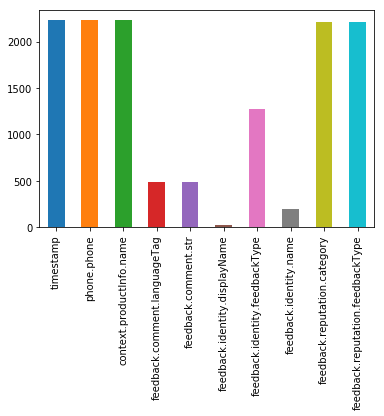

In [25]:
# replace empty strings with nan
df_no_empt = df.replace(r'^\s+$', np.nan, regex=True)
df_no_empt = df.replace('', np.nan, regex=True)
# then count and plot:
display(df_no_empt.count())
df_no_empt.count().plot.bar()

In [8]:
# what percent of feedback gives an identity name
percent_of_names = 100*(float(df_no_empt['feedback.identity.name'].count()) / df_no_empt['phone.phone'].count())
print(percent_of_names)
# what percent of feedback corrects an identity name
percent_of_names = 100*(float(df_no_empt['feedback.identity.displayName'].count()) / df_no_empt['phone.phone'].count())
print(percent_of_names)
# what percent of feedback gives an identity name, with no reputation category



8.830121021963246
0.8964589870013447


In [157]:
# category breakdown... how many identities come with a not-spam reputation category?


df_by_rep_category = df.groupby(['feedback.reputation.category']).count()[['phone.phone', 'feedback.identity.name']]
df_by_rep_category['rep_category_desc'] = ['Not Spam','General Spam','Debt Collector','Political','Nonprofit','Telemarketer','Survey','Scam or Fraud','Extortion','IRS Scam']
df_rpc1 = df_by_rep_category.replace(r'^\s+$', np.nan, regex=True)
df_rpc2 = df_rpc1.replace('', np.nan, regex=True)
df_rpc_clean = df_sams_r2.dropna()

display(pd.DataFrame(df_rpc_clean))

,feedback.identity.name
0,sandy
0,Young Living Essential Oils
0,Movistar
0,Avian Glen Maintenance
0,Victoria Defosse
0,Elwood Staffing Services
0,credit Card scam
0,inbox loans
0,Desconozco el nombre de la persona no deseo qu...
0,Sean Altamirano


In [16]:
ok_rep_cats = [1.0, 3.0, 4.0, 5.0, 6.0, 7.0]
df[df['feedback.reputation.category'].isin(ok_rep_cats)][['phone.phone', 'feedback.comment.str', 
                                                          'feedback.identity.name', 'feedback.reputation.category']]

filtered_results = identity_names[identity_names['feedback.reputation.category'].isin(ok_rep_cats)][['phone.phone', 'feedback.comment.str', 
                                                          'feedback.identity.name', 'feedback.reputation.category']]


# only show user feedback where reputation feedback wasn't reporting scam/fraud
# or other categories where impersination was likely
display(filtered_results)
filtered_results.count()


,phone.phone,feedback.comment.str,feedback.identity.name,feedback.reputation.category
0,1/4243090528,Keep calling with a different number and claim...,NaN,6.0
0,1/8056303775,"Lisa, from credit card monitoring scam",NaN,6.0
0,1/7029351036,Medicare braces,NaN,6.0
0,1/6196793816,"Back, knee",NaN,6.0
0,1/5417438198,Spoofing call . Number not in service!,NaN,6.0
0,1/6194899786,Medical device i never requested,NaN,6.0
0,1/4846672015,$##^&$%!,NaN,6.0
0,1/9724029993,Fundraiding,NaN,6.0
0,1/5592011697,Pain specialist scam.,NaN,6.0
0,1/8019208112,Reduce credit card rates,NaN,6.0


phone.phone                     150
feedback.comment.str            150
feedback.identity.name           32
feedback.reputation.category    150
dtype: int64

In [19]:
filtered_results['phone.phone'].to_csv("nums_to_id.in", index=False, header=False)
# run the offline identification process, querying all vendors for ID


In [17]:
import pandas as pd

id_df = pd.read_csv('userfeedback.out')
name_cols = id_df.filter(regex='numbers|name').columns
id_df = id_df[name_cols].drop(id_df.columns[0], axis=1)

# get columns that might contain a name
name_cols = id_df.filter(regex='name').columns
# merge
merged_ids = id_df[name_cols].stack().reset_index(level=1)
num_df = id_df['numbers'].to_frame()


df_of_ids = num_df.merge(merged_ids, left_index=True, right_index=True)

display(df_of_ids)

,numbers,level_1,0
2,1/2532799727,hiya_name,Rob Leblanc
4,1/2532799727,hiya_name,Rob Leblanc
5,52/6673143011,telo_name,Sinal
10,1/8558889618,hiya_name,Bank of Montreal Account Management
13,1/4166731299,hiya_name,Douglas Stevens
14,1/9057028921,hiya_name,Dickson Commercial Collection Agency
15,1/8185718201,hiya_name,Renee Yun
17,52/5514542590,hiya_name,Banco Invex
19,52/5570991200,telo_name,No Existe
24,1/6042964667,hiya_name,CBV Collection Services Ltd.


In [18]:
# join id results onto userfeedback names
comparison_df = pd.merge(df, df_of_ids, how='right', left_on=['phone.phone'], right_on=['numbers'])
pd.options.display.max_columns = 150
# Table comparing results of our Caller ID sources v User Feedback
display(comparison_df[comparison_df[0].notnull()][['timestamp','phone.phone',
                                                   'feedback.comment.str',
                                                   'feedback.identity.displayName',
                                                   'feedback.identity.name',
                                                   'level_1', 0]].drop_duplicates(keep=False))

,timestamp,phone.phone,feedback.comment.str,feedback.identity.displayName,feedback.identity.name,level_1,0
0,2019-04-03T13:24:57.930-07:00,52/6461271214,NaN,NaN,telcel,whitepages_name,Enrique Bernardo Courtade Pedrero
5,2019-04-03T13:34:29.790-07:00,52/6673143011,NaN,NaN,coppel,telo_name,Sinal
6,2019-04-03T14:41:19.660-06:00,52/5570991200,NaN,NaN,,telo_name,No Existe
7,2019-04-03T09:18:25.690-07:00,52/5570991200,NaN,NaN,,telo_name,No Existe
8,2019-04-03T17:41:37.880-06:00,52/5570991200,NaN,NaN,hsbc,telo_name,No Existe
9,2019-04-03T07:19:48.670-07:00,1/6042964667,NaN,NaN,,hiya_name,CBV Collection Services Ltd.
10,2019-04-03T18:06:52.680-07:00,1/6042964667,Calling all the time. Not who they are looking...,NaN,CBV Collectors,hiya_name,CBV Collection Services Ltd.
11,2019-04-03T19:48:57.870-07:00,1/6042964667,NaN,NaN,,hiya_name,CBV Collection Services Ltd.
12,2019-04-03T17:45:44.280-04:00,1/8558889618,NaN,NaN,BMO,hiya_name,Bank of Montreal Account Management
13,2019-04-03T18:25:35.270-04:00,1/4166731299,NaN,NaN,BDA Collection Services,hiya_name,Douglas Stevens


In [21]:

# plot stacked bar chart of identity name as proportion of 
identity_names_ = df[df['feedback.identity.name'].notnull() & ~df['feedback.identity.name'].isin(empties)]
display(identity_names_[['phone.phone', 'feedback.identity.name']])




,phone.phone,feedback.identity.name
0,1/9176364307,sandy
0,1/8000251548,Socual Security - Officer Victor Frank
0,1/8003713515,Young Living Essential Oils
0,1/8004339891,bank of america
0,52/5547005030,Movistar
0,1/7079801272,Avian Glen Maintenance
0,1/3065804001,Victoria Defosse
0,1/8016212770,Elwood Staffing Services
0,1/4352387773,credit Card scam
0,1/8009309066,inbox loans


,phone.phone,feedback.identity.name,feedback.reputation.category,feedback.identity.displayName,no_identity,names_as_percent
context.productInfo.name,,,,,,
HiyaAndroid,595,8,587,8,587,1.344538
MrNumberAndroid,381,11,369,12,370,2.887139
Samsung,1255,178,1255,0,1077,14.183267


1.34
2.89
14.18


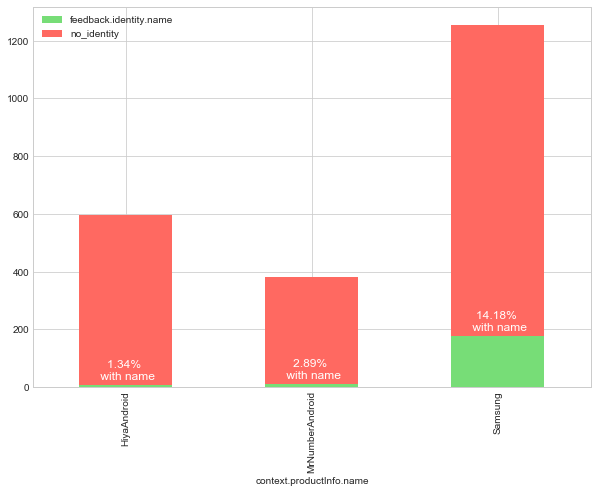

In [103]:
df_ = df_no_empt[['phone.phone','feedback.identity.name', 'context.productInfo.name','feedback.reputation.category','feedback.identity.displayName' ]]
df_grouped = df_.groupby(['context.productInfo.name']).count()
df_grouped['no_identity'] = df_grouped["phone.phone"] - df_grouped["feedback.identity.name"]
df_grouped['names_as_percent'] = (df_grouped["feedback.identity.name"]*100) / df_grouped["phone.phone"]
display(df_grouped)
colors = ['#77dd77','#ff6961']


plt.style.use('seaborn-whitegrid')


    
df_grouped.loc[:,['feedback.identity.name','no_identity']].plot.bar(stacked=True, color=colors, figsize=(10,7))

for i, v in enumerate(df_grouped['feedback.identity.name']):
    percent = df_grouped.iloc[i]['names_as_percent'].round(2)
    percent_str = "{0}% \n with name".format(percent)
    print(percent)
    plt.text(i, v+20, percent_str, fontsize=12, horizontalalignment='center', color='white')

plt.savefig('name_bd.png')
#pivot_df = df_.pivot(index='context.productInfo.name')

#display(pivot_df)

In [101]:
df['timestamp'].max()

'2019-04-04T11:59:40.340+08:00'

In [102]:
df['timestamp'].min()


'2018-09-12T18:19:23.610-06:00'

In [108]:
df.groupby(['feedback.identity.feedbackType']).count()

,timestamp,phone.phone,context.productInfo.name,feedback.comment.languageTag,feedback.comment.str,feedback.identity.displayName,feedback.identity.name,feedback.reputation.category,feedback.reputation.feedbackType
feedback.identity.feedbackType,,,,,,,,,
abstain,1255,1255,1255,136,136,0,1255,1255,1255
incorrect,20,20,20,0,0,20,20,0,0


In [134]:
df_hiya = df['feedback.identity.name'].loc[(df['context.productInfo.name']=='HiyaAndroid') | (df['context.productInfo.name']=='MrNumberAndroid')].dropna()

display(pd.DataFrame(df_hiya))

,feedback.identity.name
0,Young Living Essential Oils
0,Avian Glen Maintenance
0,Elwood Staffing Services
0,Sean Altamirano
0,John fleury
0,John fleury
0,Midland Credit collectors
0,spam
0,Bread Loan
0,Debra Kirkland


In [153]:


df_sams = df['feedback.identity.name'].loc[(df['context.productInfo.name']=='Samsung')].dropna()
df_sams_r1 = df_sams.replace(r'^\s+$', np.nan, regex=True)
df_sams_r2 = df_sams_r1.replace('', np.nan, regex=True)
df_sams_clean = df_sams_r2.dropna()
display(pd.DataFrame(df_sams_clean))

,feedback.identity.name
0,sandy
0,Socual Security - Officer Victor Frank
0,bank of america
0,Movistar
0,Victoria Defosse
0,credit Card scam
0,inbox loans
0,Desconozco el nombre de la persona no deseo qu...
0,MOVISTAR
0,coppel


In [154]:
df_sams = df['feedback.identity.name'].loc[(df['feedback.reputation.category']!=8)].dropna()
df_sams_r1 = df_sams.replace(r'^\s+$', np.nan, regex=True)
df_sams_r2 = df_sams_r1.replace('', np.nan, regex=True)
df_sams_clean = df_sams_r2.dropna()
display(pd.DataFrame(df_sams_clean))

,feedback.identity.name
0,sandy
0,Young Living Essential Oils
0,Movistar
0,Avian Glen Maintenance
0,Victoria Defosse
0,Elwood Staffing Services
0,credit Card scam
0,inbox loans
0,Desconozco el nombre de la persona no deseo qu...
0,Sean Altamirano
